# CS105 Final Project: Using Text Analysis on Movie Scripts to Predict Genre
### By: Tran Nguyen, Nina Shenoy, Carlos Miranda, Kathleen Dario

Our project idea stemmed from our collective love of movies. After learning about different machine learning + classification techniques in class, we questioned whether we could apply these concepts to movie scripts, and see if we could correctly predict the genre of a movie based on the words in it's script. The techniques we will use are tf-idf, KNN, and cosine similarity.

In [11]:
#Necessary imports for plotting, pandas, math operations, and multiple print statements.
import pandas as pd
from scipy.stats import chi2, chi2_contingency
from IPython.display import Image
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 2. Data Collection & Data Cleaning
#### (Carlos Miranda + Nina Shenoy + Tran Ngueyn + Kathleen Dario)

We retrieved our data from 2 sources: IMDb and Kaggle. The IMDB datasets were used to obtain information about the movies title, genre(s), release date, language, etc. while the Kaggle dataset was used to retrieve the movie scripts. We used inner joins to combine the 3 datasets together, using the IMDB ID as the joining factor.

After combining our datasets, we then had to filter out any unneeded entries.  The IMDb datasets contained tens of thousands of movie entries, dating as far back to the 1800's. We decided that for this project, we will only use feature-length films (excludinv tv series, short-films, etc) that were released in the years (1960-2021) that are in English, and are from the regions of US and Canada. This signifigantly reduced the size of our original dataset, which made runtime faster and easier for us to analyze.

We also noticed that some movies had more than one entry. This was because there were instances where two scripts would correspond to a particular movie. To resolve this, we got rid of the longer script, as it contained unnecessary data such as exposition, cues, and character names, and we mainly wanted to focus on dialogue.

In [12]:
# def removeDuplicates(scripts_basics_df):
#     # Key = IMDB ID , Value = Size of script
#     smallestMovieScriptMap = {}
#     # Key = IMDB ID , Value = index
#     keepIndexMap = {}

#     #show all columns
#     scripts_basics_df.dtypes

#     scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(str)

#     for index, row in scripts_basics_df.iterrows():
#         constID = row['IMDB ID']
#         currentSize = len(row['Scripts'])

#         if constID in smallestMovieScriptMap:
#             smallestSize = smallestMovieScriptMap[constID]
#             if currentSize < smallestSize:
#                 smallestMovieScriptMap[constID] = currentSize
#                 keepIndexMap[constID] = index
#         else:
#             smallestMovieScriptMap[constID] = currentSize
#             keepIndexMap[constID] = index
#     # keep this removed, this removes first instance
#     # scripts_basics_df = scripts_basics_df[~scripts_basics_df.index.duplicated(keep='first')]
#     return scripts_basics_df[scripts_basics_df.index.isin(keepIndexMap.values())]

In [13]:
# #Read basics.tsv
# basics_df = pd.read_csv("datasets/basics.tsv", sep="\t")

# #Filter basics_df
# basics_df = basics_df[basics_df["titleType"] == "movie"]
# basics_df = basics_df[basics_df["genres"] != "\\N"]
# # basics_df = basics_df[basics_df["startYear"] != "\\N"]
# # basics_df["startYear"] = basics_df["startYear"].apply(int)
# # basics_df = basics_df[basics_df["startYear"] >= 1960]
# basics_df = basics_df.set_index("tconst")

# #Filter akas_df
# akas_df = pd.read_csv("datasets/akas.tsv", sep="\t", dtype={
#     "titleId": "string", 
#     "ordering": int, 
#     "title": "string", 
#     "region":"string",
#     "language":"string"
# })

# akas_df = akas_df[akas_df["region"].isin(["US","CA"])]
# akas_df = akas_df[akas_df["language"] == "en"]
# akas_df = akas_df.set_index("titleId")

# #Join
# akas_basics_df = basics_df.join(akas_df, how='inner')


In [14]:
# #Read scripts.csv
# scripts_df = pd.read_csv("datasets/scripts.csv", dtype={
#     "IMDB ID": "string", 
#     "Scripts": "string", 
#     "release year": int, 
# });
# scripts_df = scripts_df.set_index("IMDB ID");
# scripts_df = scripts_df.drop(['genres'], axis=1)

# scripts_basics_df = akas_basics_df.join(scripts_df, how='inner')
# scripts_basics_df=scripts_basics_df.reset_index()
# scripts_basics_df = scripts_basics_df.rename(columns={'index': 'IMDB ID'})
# scripts_basics_df = removeDuplicates(scripts_basics_df)

In [15]:
#Read clean12noon.csv, which has our cleaned dataset
scripts_basics_df = pd.read_csv("datasets/arrivalMovies.csv")
scripts_basics_df = scripts_basics_df.loc[:, ~scripts_basics_df.columns.str.startswith('Unnamed')]
scripts_basics_df.head()


,IMDB ID,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,ordering,...,region,language,types,attributes,isOriginalTitle,actors,characters,movie title,release year,Scripts
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance",27,...,CA,en,imdbDisplay,\N,0,Hugh Jackman,Leopold,Kate & Leopold,2001,time time proposed fourth dimension yet mortal...
1,tt0101410,movie,Barton Fink,Barton Fink,0,1991,\N,116,"Comedy,Drama,Thriller",21,...,CA,en,imdbDisplay,\N,0,Frances McDormand,Stage Actress (voice),Barton Fink,1991,kissing goodbye four walls six flights six fli...
2,tt0101452,movie,Bill & Ted's Bogus Journey,Bill & Ted's Bogus Journey,0,1991,\N,93,"Adventure,Comedy,Fantasy",2,...,CA,en,imdbDisplay,\N,0,Keanu Reeves,Ted Logan,Bill & Ted's Bogus Journey,1991,time they've reached second crucial turning po...
3,tt0101453,movie,Billy Bathgate,Billy Bathgate,0,1991,\N,106,"Crime,Drama,Thriller",23,...,CA,en,imdbDisplay,\N,0,Dustin Hoffman,Dutch Schultz,Billy Bathgate,1991,think irving makes cheap dago move weinberg ma...
4,tt0101523,movie,The Butcher's Wife,The Butcher's Wife,0,1991,\N,107,"Comedy,Fantasy,Romance",11,...,CA,en,imdbDisplay,\N,0,Frances McDormand,Grace,The Butcher's Wife,1991,water across sea little island carolinas lived...


Since some movies were classified as having multiple genres, we ended up splitting them into multiple entries in our data set, with each entry having one genre. This made it easier for us to calculate the frequencies of the different genres.

In [16]:
scripts_basics_df["genres"] = scripts_basics_df["genres"].str.split(",")
scripts_basics_df = scripts_basics_df.explode("genres")
display(scripts_basics_df[["originalTitle", "Scripts", "genres"]])
display(scripts_basics_df["genres"].unique())

,originalTitle,Scripts,genres
0,Kate & Leopold,time time proposed fourth dimension yet mortal...,Comedy
0,Kate & Leopold,time time proposed fourth dimension yet mortal...,Fantasy
0,Kate & Leopold,time time proposed fourth dimension yet mortal...,Romance
1,Barton Fink,kissing goodbye four walls six flights six fli...,Comedy
1,Barton Fink,kissing goodbye four walls six flights six fli...,Drama
...,...,...,...
2017,SPF-18,real life movies little mixed ask sagittarius ...,Romance
2017,SPF-18,real life movies little mixed ask sagittarius ...,Sport
2018,Singularity,please use lane people close matters think thi...,Action
2018,Singularity,please use lane people close matters think thi...,Adventure


array(['Comedy', 'Fantasy', 'Romance', 'Drama', 'Thriller', 'Adventure',
       'Crime', 'Family', 'Mystery', 'Biography', 'Music', 'Horror',
       'Action', 'Sci-Fi', 'Animation', 'Sport', 'History', 'Western',
       'War', 'Musical', 'Documentary'], dtype=object)

## Exploratory Data Analysis
#### (Nina Shenoy + Kathleen Dario)

Since our topic focuses heavily on genres and scripts, we wanted to see if we could find any relationships between these two variables. The three major things we focused on are:
1. The most common film genres in our dataset.
2. Which genre(s) have the most words in their scripts, and what the average script length is for that particular genre.
3. What the most common words are in each genre.

### What are the most common film genres in our dataset?

Drama          1136
Comedy          828
Action          592
Crime           475
Romance         406
Adventure       402
Thriller        362
Mystery         197
Fantasy         159
Sci-Fi          148
Biography       109
Animation       104
Family           94
Horror           72
Sport            63
Music            50
War              21
History          20
Western          17
Musical          13
Documentary       1
Name: genres, dtype: int64


<AxesSubplot:>

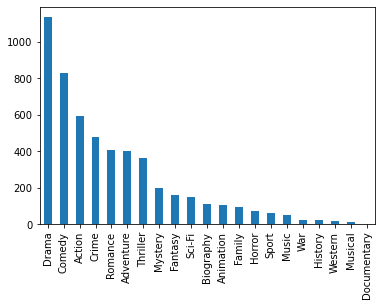

In [17]:
genre_frequency = scripts_basics_df.genres.value_counts()
print(genre_frequency)
genre_frequency.plot.bar()

As we can see per the above bar chart, the majority of the films in the dataset are classified as Drama, Comedy, and/or Action.

### Which genre(s) have the most words?

,originalTitle,Scripts,genres,Length
0,Kate & Leopold,time time proposed fourth dimension yet mortal...,Comedy,4900
0,Kate & Leopold,time time proposed fourth dimension yet mortal...,Fantasy,4900
0,Kate & Leopold,time time proposed fourth dimension yet mortal...,Romance,4900
1,Barton Fink,kissing goodbye four walls six flights six fli...,Comedy,4370
1,Barton Fink,kissing goodbye four walls six flights six fli...,Drama,4370
...,...,...,...,...
2017,SPF-18,real life movies little mixed ask sagittarius ...,Romance,3402
2017,SPF-18,real life movies little mixed ask sagittarius ...,Sport,3402
2018,Singularity,please use lane people close matters think thi...,Action,1721
2018,Singularity,please use lane people close matters think thi...,Adventure,1721


<AxesSubplot:title={'center':'Length'}, xlabel='genres'>

[Text(0, 0, 'Horror'),
 Text(1, 0, 'Animation'),
 Text(2, 0, 'Fantasy'),
 Text(3, 0, 'Thriller'),
 Text(4, 0, 'Adventure'),
 Text(5, 0, 'Mystery'),
 Text(6, 0, 'Action'),
 Text(7, 0, 'War'),
 Text(8, 0, 'Sci-Fi'),
 Text(9, 0, 'Western'),
 Text(10, 0, 'History'),
 Text(11, 0, 'Drama'),
 Text(12, 0, 'Family'),
 Text(13, 0, 'Crime'),
 Text(14, 0, 'Music'),
 Text(15, 0, 'Romance'),
 Text(16, 0, 'Musical'),
 Text(17, 0, 'Comedy'),
 Text(18, 0, 'Biography'),
 Text(19, 0, 'Sport'),
 Text(20, 0, 'Documentary')]

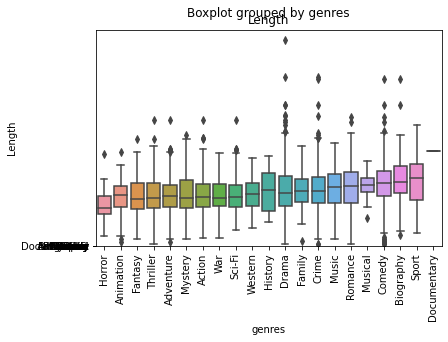

In [18]:
new_df = scripts_basics_df[["originalTitle", "Scripts", "genres"]]
new_df = new_df.dropna() #can be deleted since data should be clean before this step, kept for testing
new_df['Length'] = new_df['Scripts'].str.split(" ").str.len() # adds the length column with length of each script
display(new_df)



new_df.boxplot(column='Length',by='genres', vert=False)

grouped = new_df.groupby(['genres']).mean().sort_values(by='Length')

plot_df = sns.boxplot(x=new_df.genres, y=new_df.Length, order=grouped.index)
plot_df.set_xticklabels(plot_df.get_xticklabels(),rotation=90)

### What are the most common words in each genre?

In [28]:
from collections import Counter

# Get script for Jurassic Park (1993) and print!
# Sauce: https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/
# pd.set_option('display.max_colwidth', None)
# jp_script = scripts_basics_df.at[118, 'Scripts']
# jp_


# new_df = scripts_basics_df[["originalTitle", "Scripts", "genres"]]
# new_df = new_df.dropna() #can be deleted since data should be clean before this step, kept for testing
# new_df['Length'] = new_df['Scripts'].str.split(" ").str.len() # adds the length column with length of each script
# display(new_df)
def cleanDF(df):
    df_copy = df.copy()
    filtered_words_x = ['go', 'right', 'come', 'good', 'okay', 'one', 'would', 'want', 'think', 'see', 'back', 'hey', 'i\'m', 'i\'ll', 'that\'s','he\'s', 'can\'t', 'said', 'this']    
    df_copy['Scripts'] = df_copy['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in filtered_words_x]))
    return df_copy

words_df = scripts_basics_df[["originalTitle", "Scripts", "genres"]]
words_df = words_df.dropna()
words_df = words_df.astype({'Scripts':'string'})
# display(words_df)
# words_df.groupby(['genres'], as_index = False).agg({'val': ' '.join})
words_df = words_df.groupby(['genres']).agg({'Scripts': ' '.join})
display(words_df)

clean_df = cleanDF(words_df)
# mostCommon = Counter(words_df.loc[:'Scripts'].str.split(" ")).mostcommon()
clean_df["Most Common"] = pd.DataFrame({"MostCommon" : clean_df['Scripts'].str.split(" ").apply(lambda x: [k for k, v in Counter(x).most_common(10)])})
pd.set_option('display.max_colwidth', None)
display(clean_df[["Most Common"]])

,Most Common
genres,
Action,"[man, us, going, we're, take, look, need, time, yes, tell]"
Adventure,"[us, look, we're, going, yes, time, take, man, need, way]"
Animation,"[look, yes, us, going, we're, time, little, take, way, really]"
Biography,"[man, going, yes, look, fucking, take, us, say, time, tell]"
Comedy,"[look, really, going, yes, man, time, we're, take, say, love]"
Crime,"[man, look, going, take, tell, time, fucking, fuck, we're, need]"
Documentary,"[shit, fuck, man, put, house, kevin, say, fucking, people, look]"
Drama,"[going, man, look, yes, time, take, tell, say, us, really]"
Family,"[look, going, time, little, really, yes, take, we're, us, let's]"


# Analysis + Techniques
#### (Tran Nguyen)

KNN

Cosine Similarity

tf-idf